# ORF 350, HW 7 
Team: Millian Gehrer, Nicholas Johnson

net_ids: mgehrer, nagj

# Initial Processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil import parser, rrule

In [2]:
# import trip data 
trips = pd.read_csv('OD_2018-04.csv')
trips = trips.append(pd.read_csv('OD_2018-05.csv'))
trips = trips.append(pd.read_csv('OD_2018-06.csv'))
trips = trips.append(pd.read_csv('OD_2018-07.csv'))
trips = trips.append(pd.read_csv('OD_2018-08.csv'))
trips = trips.append(pd.read_csv('OD_2018-09.csv'))
trips = trips.append(pd.read_csv('OD_2018-10.csv'))
trips = trips.append(pd.read_csv('OD_2018-11.csv'))
n_trips = trips.shape[0]

In [3]:
# add month, day, hour to trips
trips['start_date'] = pd.to_datetime(trips['start_date'])
trips['end_date'] = pd.to_datetime(trips['end_date'])
trips['month'] = trips['start_date'].dt.month
trips['weekday'] = trips['start_date'].dt.weekday
trips['hour'] = trips['start_date'].dt.hour
trips['round_to_hour'] = trips['start_date'].dt.round("H")
trips['date'] = trips['start_date'].dt.date

In [4]:
# import temp data
temp = pd.read_csv('temp18.csv')
# fill blanks/NaN
fill_in = temp.iloc[2327,6]
temp.iloc[2328,6] = fill_in
temp.iloc[2329,6] = fill_in

In [5]:
# dictionary of temp data
t = pd.concat([temp['Date/Time'], temp['Temperature']], axis=1)
t['Date/Time'] = pd.to_datetime(t['Date/Time'])
t_dict = t.set_index('Date/Time').T.to_dict('list')

In [6]:
# import precipitation data
precip = pd.read_csv('daily_18.csv')
# dictionary of rain data
rain = pd.concat([precip['Date/Time'], precip['Total Rain (mm)']], axis=1)
rain['Date/Time'] = pd.to_datetime(rain['Date/Time'])
rain['Date/Time'] = rain['Date/Time'].dt.date
rain = rain.fillna(0)
rain_dict = rain.set_index('Date/Time').T.to_dict('list')
# dictionary of snow data
snow = pd.concat([precip['Date/Time'], precip['Total Snow (cm)']], axis=1)
snow['Date/Time'] = pd.to_datetime(snow['Date/Time'])
snow['Date/Time'] = snow['Date/Time'].dt.date
snow = snow.fillna(0)
snow_dict = snow.set_index('Date/Time').T.to_dict('list')

In [7]:
# map weather data to trip dataframe
trips['Temp'] = trips['round_to_hour'].map(t_dict)
trips['Rain'] = trips['date'].map(rain_dict)
trips['Snow'] = trips['date'].map(snow_dict)
temp2 = [trips['Temp'].values[i][0] for i in np.arange(n_trips)]
rain2 = [trips['Rain'].values[i][0] for i in np.arange(n_trips)]
snow2 = [trips['Snow'].values[i][0] for i in np.arange(n_trips)]
trips['Temp'] = temp2
trips['Rain'] = rain2
trips['Snow'] = snow2

In [8]:
# compute trip volumes 
# compute number of bikes checked out
first = min(trips['start_date'])
last = max(trips['end_date'])
vol_time = list(rrule.rrule(freq=rrule.MINUTELY, dtstart=first, until=last))
vol_val = np.zeros(len(vol_time))
vol_dict = dict(zip(vol_time, vol_val))

# fill volume dictionary
for i in np.arange(n_trips):
    start = trips['start_date'].iloc[i]
    end = trips['end_date'].iloc[i]
    for j in list(rrule.rrule(freq=rrule.MINUTELY, dtstart=start, until=end)):
        vol_dict[j] += 1
trips['volume'] = trips['start_date'].map(vol_dict)

In [9]:
volume = trips['volume'].values

# Natural Data

In [10]:
# natural data
natural = pd.concat([trips['Temp'], trips['Rain'], trips['Snow'], 
                   trips['hour'], trips['weekday'], trips['month'],
                     trips['volume']], axis=1)

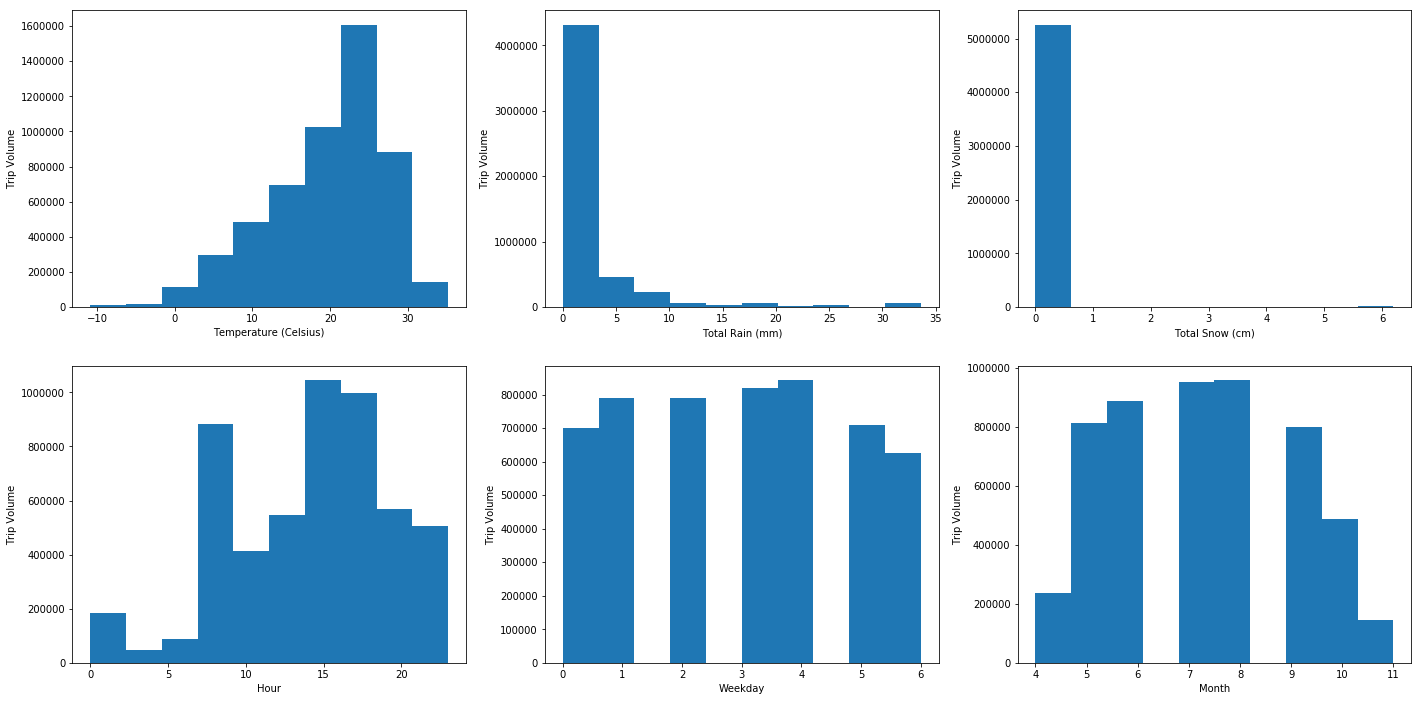

In [11]:
# histograms
plt.figure(figsize=(24, 12))
labels = ['Temperature (Celsius)', 'Total Rain (mm)', 'Total Snow (cm)',
         'Hour', 'Weekday', 'Month']
for i in np.arange(6):
    plt.subplot(2,3,i+1)
    plt.hist(natural.values[:,i])
    plt.ylabel('Trip Volume')
    plt.xlabel(labels[i])

In [12]:
X_pd_n = pd.concat([natural['Temp'], natural['Rain'], natural['Snow'], 
                   natural['hour'], natural['weekday'], natural['month']], axis=1)
X_matrix_n = X_pd_n.astype(float).values

# Engineered Data

In [13]:
# engineered data
eng = natural
# weekday processing 
eng['weekday'] = eng['weekday'].replace(np.arange(5), 1)
eng['weekday'] = eng['weekday'].replace(5, 0)
eng['weekday'] = eng['weekday'].replace(6, 0)
# rain processing
eng['Rain'][eng['Rain'] > 0] = 1
# snow processing
eng['Snow'][eng['Snow'] > 0] = 1
# season processing 
eng['month'] = eng['month'].replace(np.arange(5,10), 1)
eng['month'] = eng['month'].replace(4, 0)
eng['month'] = eng['month'].replace(np.arange(10,13), 0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


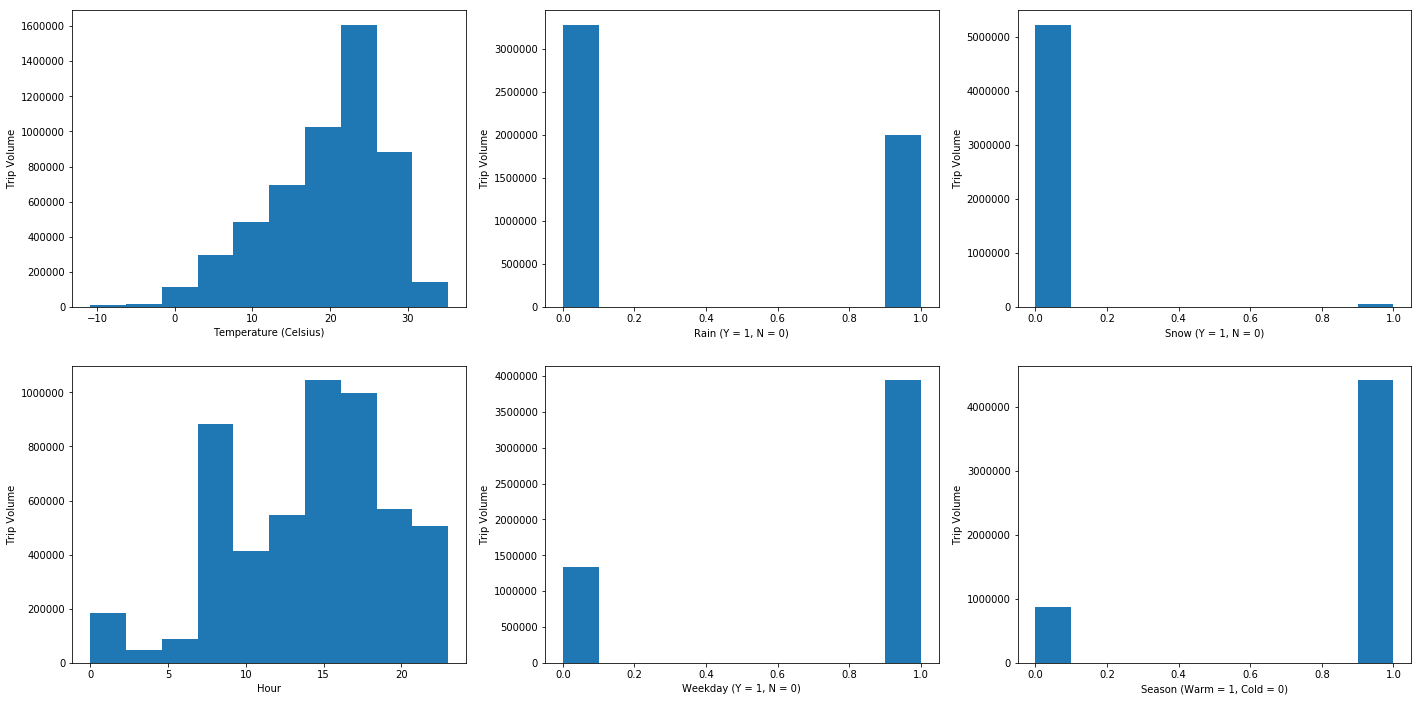

In [14]:
# histograms
plt.figure(figsize=(24, 12))
labels = ['Temperature (Celsius)', 'Rain (Y = 1, N = 0)', 'Snow (Y = 1, N = 0)',
         'Hour', 'Weekday (Y = 1, N = 0)', 'Season (Warm = 1, Cold = 0)']
for i in np.arange(6):
    plt.subplot(2,3,i+1)
    plt.hist(natural.values[:,i])
    plt.ylabel('Trip Volume')
    plt.xlabel(labels[i])

In [15]:
X_pd_e = pd.concat([eng['Temp'], eng['Rain'], eng['Snow'], 
                   eng['hour'], eng['weekday'], eng['month']], axis=1)
X_matrix_e = X_pd_e.astype(float).values

# Error Functions

In [16]:
def rmse(y, y_hat):
    n_test = len(y)
    error = 1/n_test * np.sqrt(sum((y - y_hat)**2))
    return error

In [17]:
def percent_error(y, y_hat):
    error = np.mean(np.divide(np.abs(y_hat-y),y))
    return error

# Linear Least Squares Regression

In [18]:
from sklearn.linear_model import LinearRegression

In [19]:
np.random.seed(2)
# use 70% of dataset for training, rest for testing
n_train = int(n_trips*0.70)
train_id = np.random.choice(n_trips, n_train, replace=False)
test_id = np.array(list(set(range(n_trips))-set(train_id)))
n_test = n_trips - n_train
# training datasets
X_train_n = X_matrix_n[train_id,:]
X_train_e = X_matrix_e[train_id,:]
y_train = volume[train_id]
# testing datset
X_test_n = X_matrix_n[test_id,:]
X_test_e = X_matrix_e[test_id,:]
y_test = volume[test_id]

In [20]:
# regression on natural data
lin_reg_n = LinearRegression().fit(X_train_n, y_train)
y_predict_n = lin_reg_n.predict(X_test_n)
print('Natural Data RMSE: ', rmse(y_predict_n, y_test))
print('Natural Data Mean Absolute Percent Error: ', 
      percent_error(y_predict_n, y_test))

Natural Data RMSE:  0.17474105284094713
Natural Data Mean Absolute Percent Error:  0.42558614802786826


In [21]:
# regression on engineered data
lin_reg_e = LinearRegression().fit(X_train_e, y_train)
y_predict_e = lin_reg_n.predict(X_test_e)
print('Engineered Data RMSE: ', rmse(y_predict_e, y_test))
print('Engineered Data Mean Absolute Percent Error: ', 
      percent_error(y_predict_e, y_test))

Engineered Data RMSE:  0.1899118608592448
Engineered Data Mean Absolute Percent Error:  0.40862151810216363


# Decision Tree

In [22]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import graphviz
from sklearn import tree

In [23]:
# parameter testing
parameters = {'min_samples_leaf': [10,50,100,250,500,750,1000,
                                   1250,1500,1750,2000]}

In [24]:
# fit natural data
dec_tree_n = DecisionTreeRegressor()
fit_n = GridSearchCV(dec_tree_n, parameters, cv=5, refit = True)
fit_n.fit(X_train_n, y_train)
tree_predict_n = fit_n.predict(X_test_n)
opt_n = fit_n.best_params_
print('Best min_samples_leaf Parameter: ', opt_n)
print('Natural Data RMSE: ', rmse(tree_predict_n, y_test))
print('Natural Data Mean Absolute Percent Error: ', 
      percent_error(tree_predict_n, y_test))

Best min_samples_leaf Parameter:  {'min_samples_leaf': 10}
Natural Data RMSE:  0.031603801623965956
Natural Data Mean Absolute Percent Error:  0.06684665334338381


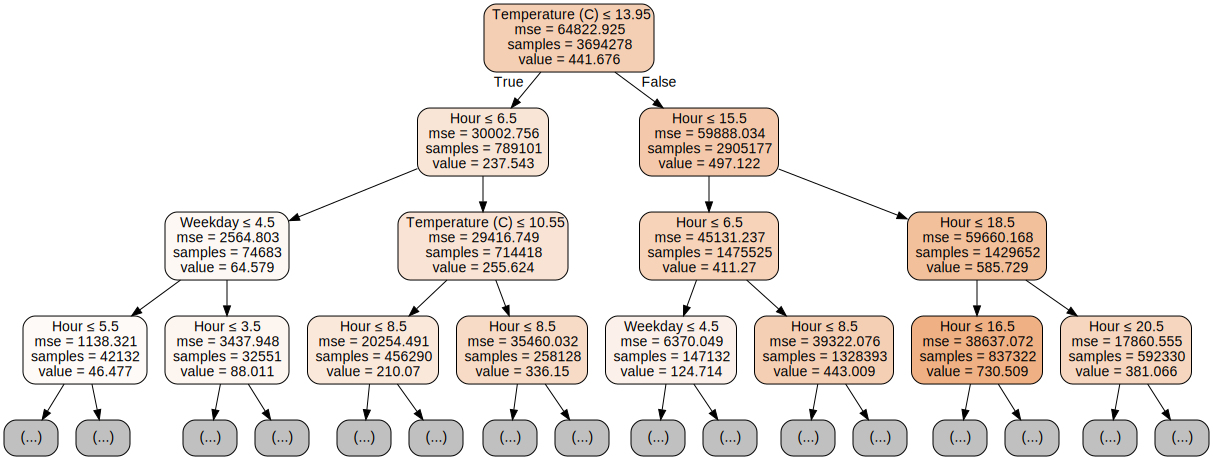

In [53]:
# show top of tree with min_leaf_nodes = 10, natural data
tree_10_n = DecisionTreeRegressor(min_samples_leaf = 10)
tree_10_n.fit(X_train_n, y_train)
tree_10_predict_n = tree_10_n.predict(X_test_n)
labels = ['Temperature (C)', 'Total Rain (mm)', 'Total Snow (cm)',
         'Hour', 'Weekday', 'Month']
dot_data = tree.export_graphviz(tree_10_n, out_file=None, 
                                max_depth=3, filled=True, 
                                rounded=True,special_characters=True
                               , feature_names = labels)
graph = graphviz.Source(dot_data)
graph.render(filename='tree.dot')
graph

In [26]:
# fit engineered data
dec_tree_e = DecisionTreeRegressor()
fit_e = GridSearchCV(dec_tree_e, parameters, cv=5, refit = True)
fit_e.fit(X_train_e, y_train)
tree_predict_e = fit_e.predict(X_test_e)
opt_e = fit_e.best_params_
print('Best min_samples_leaf Parameter: ', opt_e)
print('Engineered Data RMSE: ', rmse(tree_predict_e, y_test))
print('Engineered Data Mean Absolute Percent Error: ', 
      percent_error(tree_predict_e, y_test))

Best min_samples_leaf Parameter:  {'min_samples_leaf': 10}
Engineered Data RMSE:  0.04531924724242459
Engineered Data Mean Absolute Percent Error:  0.09114498737257624


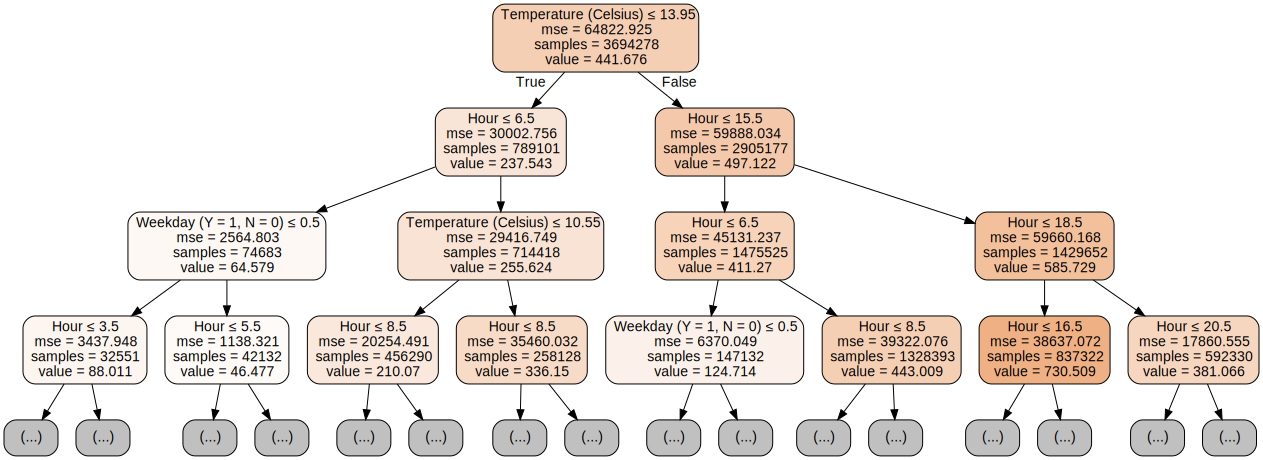

In [55]:
# show top of tree with min_leaf_nodes = 10, engineered data
tree_2K_e = DecisionTreeRegressor(min_samples_leaf = 10)
tree_2K_e.fit(X_train_e, y_train)
tree_2K_predict_e = tree_2K_e.predict(X_test_e)
labels = ['Temperature (Celsius)', 'Rain (Y = 1, N = 0)', 'Snow (Y = 1, N = 0)',
         'Hour', 'Weekday (Y = 1, N = 0)', 'Season (Warm = 1, Cold = 0)']
dot_data = tree.export_graphviz(tree_2K_e, 
                                out_file=None, filled=True, 
                                max_depth=3, rounded=True,special_characters=True,
                                feature_names = labels)
graph = graphviz.Source(dot_data)
graph.render(filename='tree2.dot')
graph

# Random Forests

In [31]:
from sklearn.ensemble import RandomForestRegressor

In [32]:
rmse_vec_n = np.zeros(10)
percent_vec_n = np.zeros(10)

In [33]:
for i in [10,20,30,40,50,60,70,80,90,100]:
    rf = RandomForestRegressor(min_samples_leaf = 10, n_estimators = i)
    rf.fit(X_train_n, y_train)
    rf_predict = rf.predict(X_test_n)
    rmse_vec_n[int(i/10)-1] = rmse(rf_predict, y_test)
    percent_vec_n[int(i/10)-1] = percent_error(rf_predict, y_test)

In [35]:
rmse_vec = np.zeros(10)
percent_vec = np.zeros(10)

In [36]:
for i in [10,20,30,40,50,60,70,80,90,100]:
    rf = RandomForestRegressor(min_samples_leaf = 10, n_estimators = i)
    rf.fit(X_train_e, y_train)
    rf_predict = rf.predict(X_test_e)
    rmse_vec[int(i/10)-1] = rmse(rf_predict, y_test)
    percent_vec[int(i/10)-1] = percent_error(rf_predict, y_test)

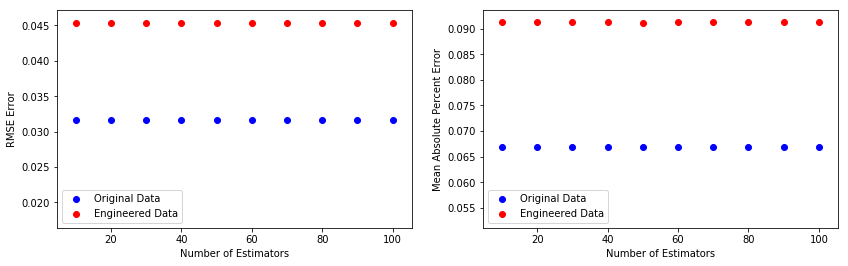

In [37]:
plt.figure(figsize=(14, 4))
plt.subplot(121)
plt.scatter(np.arange(10,110,10), rmse_vec_n, c='b')
plt.scatter(np.arange(10,110,10), rmse_vec, c='r')
plt.ylabel('RMSE Error')
plt.xlabel('Number of Estimators')
plt.legend(['Original Data', 'Engineered Data'])
plt.subplot(122)
plt.scatter(np.arange(10,110,10), percent_vec_n, c='b')
plt.scatter(np.arange(10,110,10), percent_vec, c='r')
plt.ylabel('Mean Absolute Percent Error')
plt.xlabel('Number of Estimators')
plt.legend(['Original Data', 'Engineered Data'])
plt.show()

# Multilayer Perceptron

Note: This portion of the notebook was run in a cluster, as it would take too long to run in Jupyter notebook. Please see the results in our written report. 

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split as partition

In [ ]:
# data preprocessing
data = pd.read_csv('natural_data.csv')
new_data = data.drop(columns=['Unnamed: 0'])
all_data = new_data.values
X_matrix = all_data[:,0:6]
Y = all_data[:,6]
X_train, X_test, Y_train, Y_test = partition(X_matrix,Y,test_size=0.2)

In [ ]:
# train model
epochs = 40

In [ ]:
def rmse(y_true, y_pred):
    n = Y_train.shape[0]
    return (K.sqrt(K.sum(K.square(y_pred - y_true))))/n
def rel_error(y_true, y_pred):
    return K.mean(K.abs(np.divide(y_pred - y_true,y_true)))

In [ ]:
model = tf.keras.models.Sequential([
                tf.keras.layers.Dense(400, kernel_initializer='normal', activation = tf.nn.relu),
                tf.keras.layers.Dense(300, kernel_initializer='normal', activation = tf.nn.relu),
                tf.keras.layers.Dense(200, kernel_initializer='normal', activation = tf.nn.relu),
                tf.keras.layers.Dense(100, kernel_initializer='normal', activation = tf.nn.relu),
                tf.keras.layers.Dense(1,  kernel_initializer='normal', activation = tf.nn.relu)
        ])

model.reset_states()

model.compile(optimizer='adam', loss='mse', metrics=['mse', rmse, rel_error])

history = model.fit(X_train, Y_train, epochs = epochs, verbose = 1)
    
(loss, mse, rmse_val, rel) = model.evaluate(X_train, Y_train, verbose = 1)

plt.figure()
plt.plot(history.history['rmse'])
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.title('Root Mean Square Error versus Training Epoch')
plt.savefig('rmse')
plt.close()

plt.figure()
plt.plot(history.history['rel_error'])
plt.ylabel('Mean Absolute Percent Error')
plt.xlabel('Epoch')
plt.title('Mean Absolute Percent Error versus Training Epoch')
plt.savefig('rel_error')
plt.close()

final_rmse = (Y_train.shape[0]*rmse_val)/(Y_test.shape[0])
print('The final Root Mean Square Error is: ' + str(rmse_val))
print('The final Mean Absolute Percent Error is: ' + str(rel))